In [1]:
%pip install -q torch --upgrade
%pip install -q foolbox

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import time
import copy
import random

import numpy as np

import torch
import torch.nn.functional as F

from torch import nn
from torch import linalg
from torch.optim import SGD, Optimizer
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms, datasets, models

import foolbox as fb

import matplotlib.pyplot as plt

from utils_ods_attack import ods_attack
from utils_general import train, test, short_test
from utils_attacks import whitebox_attack

In [3]:
# reproducibility issues
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
dataset_cifar_train = datasets.CIFAR100(
    root="./",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
dataset_cifar_valid_test = datasets.CIFAR100(
    root="./",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
print(dataset_cifar_train[1][0].size(), len(dataset_cifar_train), len(dataset_cifar_valid_test))

dataset_cifar_valid, dataset_cifar_test = torch.utils.data.random_split(dataset_cifar_valid_test, [5000, 5000], 
                                                                        generator=torch.Generator().manual_seed(42))

data_loader_cifar_train = DataLoader(dataset_cifar_train, batch_size=128, shuffle=True)
data_loader_cifar_valid = DataLoader(dataset_cifar_valid, batch_size=128, shuffle=False)
data_loader_cifar_test = DataLoader(dataset_cifar_test, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32]) 50000 10000


In [5]:
class OurResNetModel(nn.Module):
    """
    Small class to initialize ResNet
    
    """
    def __init__(self, pretrained_bool, num_of_classes):
        super().__init__()
        
        self.model_resnet = models.resnet34(pretrained=pretrained_bool) # 18 34 50 101 152
        self.model_resnet.fc = nn.Linear(self.model_resnet.fc.in_features, num_of_classes, bias=False)

    def forward(self, x):
        return self.model_resnet(x)

In [6]:
#!g1.1
# optimzer and scheduler params
learning_rate_, weight_decay_ = 0.01, 0.001
step_size_, gamma_ = 2, 0.7

# level of noise, and ODS params
noise_sd_, nu_, num_of_steps_ = 0.1, 0.1, 1

# dataloader and parameters for attacks
data_loader_cifar_test_ = DataLoader(dataset_cifar_test, batch_size=5000, shuffle=False)
epsilons_ = [0.0, 0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1.0]

In [7]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = OurResNetModel(True, 100)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate_, momentum=0.0, weight_decay=weight_decay_)
scheduler = StepLR(optimizer, step_size=step_size_, gamma=gamma_)

valid_loss_, valid_acc_ = 0, 0
for epoch in range(10):
    print(f'Epoch {epoch + 1}\n')
    train_loss, train_acc = train(data_loader_cifar_train, model, criterion, optimizer, device=device,
                                  augment=False, noise_sd=noise_sd_, attack=False, nu=nu_, num_of_steps=num_of_steps_) # ; print()
    valid_loss, valid_acc = test(data_loader_cifar_valid, model, criterion, device=device,
                                 augment=False, noise_sd=noise_sd_, attack=False, nu=nu_, num_of_steps=num_of_steps_); print()
    scheduler.step()
    
    if valid_acc > valid_acc_ * 1.01:
        valid_acc_ = valid_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join('checkpoint_baseline.pth.tar'))
    else:
        print("Early stopping")
        checkpoint = torch.load('checkpoint_baseline.pth.tar')
        model.load_state_dict(checkpoint['state_dict'])
        break

model.to(torch.device('cpu')); print()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



Epoch 1

Train (after 150 batches): Current time: 0.016 (mean: 0.016) Current loss: 3.098 (mean: 4.039) Current accuracy: 0.305 (mean: 0.127) 
Train (after 300 batches): Current time: 0.016 (mean: 0.016) Current loss: 2.873 (mean: 3.461) Current accuracy: 0.250 (mean: 0.213) 
Validation (after 40 batches): Current time: 0.005 (mean: 0.007) Current loss: 1.749 (mean: 2.342) Current accuracy: 0.500 (mean: 0.373) 

Epoch 2

Train (after 150 batches): Current time: 0.016 (mean: 0.016) Current loss: 2.056 (mean: 2.146) Current accuracy: 0.453 (mean: 0.432) 
Train (after 300 batches): Current time: 0.016 (mean: 0.016) Current loss: 2.069 (mean: 2.084) Current accuracy: 0.445 (mean: 0.444) 
Validation (after 40 batches): Current time: 0.005 (mean: 0.007) Current loss: 1.725 (mean: 2.015) Current accuracy: 0.500 (mean: 0.456) 

Epoch 3

Train (after 150 batches): Current time: 0.015 (mean: 0.016) Current loss: 1.794 (mean: 1.635) Current accuracy: 0.500 (mean: 0.552) 
Train (after 300 batches

In [8]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Accuracy on train set: {short_test(data_loader_cifar_train, model, device=device)}%')
print(f'Accuracy on valid set: {short_test(data_loader_cifar_valid, model, device=device)}%')
print(f'Accuracy on test  set: {short_test(data_loader_cifar_test, model, device=device)}%')

Accuracy on train set: 77.894%
Accuracy on valid set: 51.84%
Accuracy on test  set: 52.52%


In [9]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

baseline_CW = whitebox_attack(model, data_loader_cifar_test_, attack_name='CW', epsilons=epsilons_, 
                              plot=False, aug_type='baseline', device=device)
baseline_PGD = whitebox_attack(model, data_loader_cifar_test_, attack_name='PGD', epsilons=epsilons_, 
                               plot=False, aug_type='baseline', device=device)
baseline_LinfPGD = whitebox_attack(model, data_loader_cifar_test_, attack_name='LinfPGD', epsilons=epsilons_, 
                                   plot=False, aug_type='baseline', device=device)
baseline_LinfFastGradientAttack = whitebox_attack(model, data_loader_cifar_test_, attack_name='LinfFastGradientAttack', epsilons=epsilons_, 
                                                  plot=False, aug_type='baseline', device=device)

Clear accuracy on images without adversarial attack 0.5252000093460083
Clear accuracy on images without adversarial attack 0.5252000093460083
Clear accuracy on images without adversarial attack 0.5252000093460083
Clear accuracy on images without adversarial attack 0.5252000093460083


In [10]:
#!g1.1
del model, criterion, optimizer, scheduler

In [11]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = OurResNetModel(True, 100)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate_, momentum=0.0, weight_decay=weight_decay_)
scheduler = StepLR(optimizer, step_size=step_size_, gamma=gamma_)

valid_loss_, valid_acc_ = 0, 0
for epoch in range(10):
    print(f'Epoch {epoch + 1}\n')
    train_loss, train_acc = train(data_loader_cifar_train, model, criterion, optimizer, device=device,
                                  augment=True, noise_sd=noise_sd_, attack=False, nu=nu_, num_of_steps=num_of_steps_); print()
    valid_loss, valid_acc = test(data_loader_cifar_valid, model, criterion, device=device,
                                 augment=True, noise_sd=noise_sd_, attack=False, nu=nu_, num_of_steps=num_of_steps_); print()
    scheduler.step()
    
    if valid_acc > valid_acc_ * 1.01:
        valid_acc_ = valid_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join('checkpoint_pixeldp.pth.tar'))
    else:
        print("Early stopping")
        checkpoint = torch.load('checkpoint_pixeldp.pth.tar')
        model.load_state_dict(checkpoint['state_dict'])
        break

model.to(torch.device('cpu')); print()

Epoch 1

Train (after 150 batches): Current time: 0.016 (mean: 0.016) Current loss: 3.442 (mean: 4.104) Current accuracy: 0.195 (mean: 0.110) 
Train (after 300 batches): Current time: 0.016 (mean: 0.016) Current loss: 2.747 (mean: 3.600) Current accuracy: 0.312 (mean: 0.183) 

Validation (after 40 batches): Current time: 0.005 (mean: 0.007) Current loss: 2.308 (mean: 2.626) Current accuracy: 0.375 (mean: 0.331) 

Epoch 2

Train (after 150 batches): Current time: 0.016 (mean: 0.016) Current loss: 2.363 (mean: 2.470) Current accuracy: 0.336 (mean: 0.366) 
Train (after 300 batches): Current time: 0.016 (mean: 0.016) Current loss: 2.307 (mean: 2.397) Current accuracy: 0.391 (mean: 0.378) 

Validation (after 40 batches): Current time: 0.005 (mean: 0.007) Current loss: 2.156 (mean: 2.280) Current accuracy: 0.500 (mean: 0.395) 

Epoch 3

Train (after 150 batches): Current time: 0.018 (mean: 0.017) Current loss: 1.907 (mean: 2.025) Current accuracy: 0.477 (mean: 0.461) 
Train (after 300 batche

In [12]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Accuracy on train set: {short_test(data_loader_cifar_train, model, device=device)}%')
print(f'Accuracy on valid set: {short_test(data_loader_cifar_valid, model, device=device)}%')
print(f'Accuracy on test  set: {short_test(data_loader_cifar_test, model, device=device)}%')

Accuracy on train set: 38.928%
Accuracy on valid set: 33.8%
Accuracy on test  set: 33.76%


In [13]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

pixeldp_CW = whitebox_attack(model, data_loader_cifar_test_, attack_name='CW', epsilons=epsilons_, 
                             plot=False, aug_type='pixeldp', device=device)
pixeldp_PGD = whitebox_attack(model, data_loader_cifar_test_, attack_name='PGD', epsilons=epsilons_, 
                              plot=False, aug_type='pixeldp', device=device)
pixeldp_LinfPGD = whitebox_attack(model, data_loader_cifar_test_, attack_name='LinfPGD', epsilons=epsilons_, 
                                  plot=False, aug_type='pixeldp', device=device)
pixeldp_LinfFastGradientAttack = whitebox_attack(model, data_loader_cifar_test_, attack_name='LinfFastGradientAttack', epsilons=epsilons_, 
                                                 plot=False, aug_type='pixeldp', device=device)

Clear accuracy on images without adversarial attack 0.3375999927520752
Clear accuracy on images without adversarial attack 0.3375999927520752
Clear accuracy on images without adversarial attack 0.3375999927520752
Clear accuracy on images without adversarial attack 0.3375999927520752


In [14]:
#!g1.1
del model, criterion, optimizer, scheduler

In [15]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = OurResNetModel(True, 100)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate_, momentum=0.0, weight_decay=weight_decay_)
scheduler = StepLR(optimizer, step_size=step_size_, gamma=gamma_)

valid_loss_, valid_acc_ = 0, 0
for epoch in range(10):
    print(f'Epoch {epoch + 1}\n')
    train_loss, train_acc = train(data_loader_cifar_train, model, criterion, optimizer, device=device,
                                  augment=True, noise_sd=noise_sd_, attack=True, nu=nu_, num_of_steps=num_of_steps_); print()
    valid_loss, valid_acc = test(data_loader_cifar_valid, model, criterion, device=device,
                                 augment=True, noise_sd=noise_sd_, attack=True, nu=nu_, num_of_steps=num_of_steps_); print()
    scheduler.step()
    
    if valid_acc > valid_acc_ * 1.01:
        valid_acc_ = valid_acc
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join('checkpoint_ods.pth.tar'))
    else:
        print("Early stopping")
        checkpoint = torch.load('checkpoint_ods.pth.tar')
        model.load_state_dict(checkpoint['state_dict'])
        break

model.to(torch.device('cpu')); print()

Epoch 1

Train (after 150 batches): Current time: 0.250 (mean: 0.243) Current loss: 3.213 (mean: 4.020) Current accuracy: 0.250 (mean: 0.121) 
Train (after 300 batches): Current time: 0.246 (mean: 0.245) Current loss: 2.774 (mean: 3.457) Current accuracy: 0.336 (mean: 0.206) 

Validation (after 40 batches): Current time: 0.243 (mean: 0.239) Current loss: 2.093 (mean: 2.406) Current accuracy: 0.375 (mean: 0.376) 

Epoch 2

Train (after 150 batches): Current time: 0.248 (mean: 0.246) Current loss: 2.012 (mean: 2.191) Current accuracy: 0.414 (mean: 0.421) 
Train (after 300 batches): Current time: 0.242 (mean: 0.247) Current loss: 2.044 (mean: 2.136) Current accuracy: 0.461 (mean: 0.434) 

Validation (after 40 batches): Current time: 0.225 (mean: 0.238) Current loss: 1.543 (mean: 2.038) Current accuracy: 0.375 (mean: 0.453) 

Epoch 3

Train (after 150 batches): Current time: 0.246 (mean: 0.248) Current loss: 1.616 (mean: 1.739) Current accuracy: 0.539 (mean: 0.529) 
Train (after 300 batche

In [16]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'Accuracy on train set: {short_test(data_loader_cifar_train, model, device=device)}%')
print(f'Accuracy on valid set: {short_test(data_loader_cifar_valid, model, device=device)}%')
print(f'Accuracy on test  set: {short_test(data_loader_cifar_test, model, device=device)}%')

Accuracy on train set: 78.162%
Accuracy on valid set: 53.42%
Accuracy on test  set: 53.92%


In [17]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ods_CW = whitebox_attack(model, data_loader_cifar_test_, attack_name='CW', epsilons=epsilons_, 
                         plot=False, aug_type='ODS', device=device)
ods_PGD = whitebox_attack(model, data_loader_cifar_test_, attack_name='PGD', epsilons=epsilons_, 
                          plot=False, aug_type='ODS', device=device)
ods_LinfPGD = whitebox_attack(model, data_loader_cifar_test_, attack_name='LinfPGD', epsilons=epsilons_, 
                              plot=False, aug_type='ODS', device=device)
ods_LinfFastGradientAttack = whitebox_attack(model, data_loader_cifar_test_, attack_name='LinfFastGradientAttack', epsilons=epsilons_, 
                                             plot=False, aug_type='ODS', device=device)

Clear accuracy on images without adversarial attack 0.5392000079154968
Clear accuracy on images without adversarial attack 0.5392000079154968
Clear accuracy on images without adversarial attack 0.5392000079154968
Clear accuracy on images without adversarial attack 0.5392000079154968


In [18]:
#!g1.1
del model, criterion, optimizer, scheduler

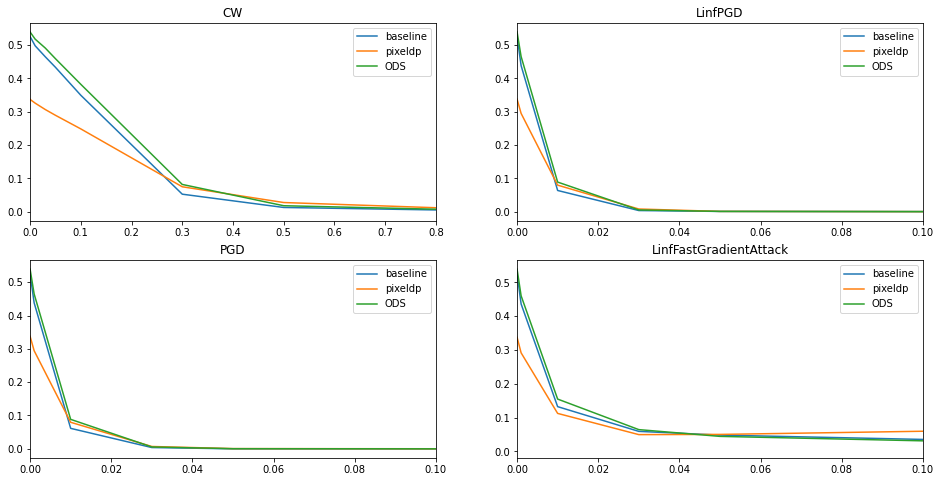

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

ax[0, 0].plot(epsilons_, baseline_CW, label='baseline')
ax[0, 0].plot(epsilons_, pixeldp_CW, label='pixeldp')
ax[0, 0].plot(epsilons_, ods_CW, label='ODS')

# ax[0, 0].set_yscale('log')
ax[0, 0].set_xlim(0., 0.8)
ax[0, 0].legend()
ax[0, 0].set_title('CW')

ax[1, 0].plot(epsilons_, baseline_PGD, label='baseline')
ax[1, 0].plot(epsilons_, pixeldp_PGD, label='pixeldp')
ax[1, 0].plot(epsilons_, ods_PGD, label='ODS')

# ax[1, 0].set_yscale('log')
ax[1, 0].set_xlim(0., 0.1)
ax[1, 0].legend()
ax[1, 0].set_title('PGD')

ax[0, 1].plot(epsilons_, baseline_LinfPGD, label='baseline')
ax[0, 1].plot(epsilons_, pixeldp_LinfPGD, label='pixeldp')
ax[0, 1].plot(epsilons_, ods_LinfPGD, label='ODS')

# ax[0, 1].set_yscale('log')
ax[0, 1].set_xlim(0., 0.1)
ax[0, 1].legend()
ax[0, 1].set_title('LinfPGD')

ax[1, 1].plot(epsilons_, baseline_LinfFastGradientAttack, label='baseline')
ax[1, 1].plot(epsilons_, pixeldp_LinfFastGradientAttack, label='pixeldp')
ax[1, 1].plot(epsilons_, ods_LinfFastGradientAttack, label='ODS')

# ax[1, 1].set_yscale('log')
ax[1, 1].set_xlim(0., 0.1)
ax[1, 1].legend()
ax[1, 1].set_title('LinfFastGradientAttack')

plt.show()